# Snow entity learning with LightGBM

For comments, see the example on learning using XGBoost library.

Results from XGBoost and LightGBM are almost the same. However, LightGBM is faster.

In [1]:
%matplotlib inline

from __future__ import print_function
import os
import os.path as osp
import numpy as np

import pysptools.ml as ml
import pysptools.skl as skl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
    

#def tune():
#    return {'boosting_type':"gbdt", 'num_leaves':31, 'max_depth':-1,
#                 'learning_rate':0.1, 'n_estimators':10, 'max_bin':255,
#                 'subsample_for_bin':50000, 'objective':None,
#                 'min_split_gain':0., 'min_child_weight':5, 'min_child_samples':10}

def tune():
    return {'boosting_type':"gbdt", 'num_leaves':10, 'max_depth':20,
            'learning_rate':0.1, 'n_estimators':10,
            'subsample_for_bin':50000, 'objective':None,
            'min_split_gain':0., 'min_child_weight':5, 'min_child_samples':10}


def fit_model(rpath, X_train, y_train, X_test, y_test, estimator, param, stat=False):
    model = estimator(**param)
    model.fit(X_train, y_train)
    if stat == True:
        accuracy(model, X_test, y_test)
    if rpath == None:
        model.display_feature_importances(sort=True, n_labels='all')
    else:
        model.plot_feature_importances(rpath, sort=True, n_labels='all')
    return model


def accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    ## evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    

home_path = os.environ['HOME']
source_path = osp.join(home_path, 'dev-data/CZ_hsdb')
result_path = None

# First step: build snow spectra set

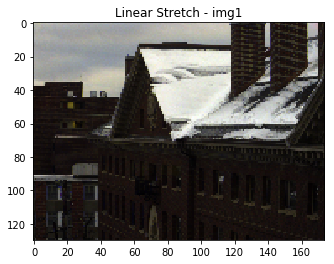

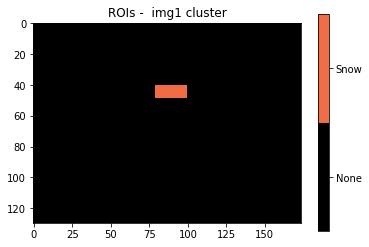

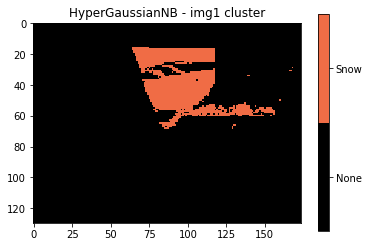

In [2]:
# img1
img1_scaled, img1_cmap = ml.get_scaled_img_and_class_map(source_path, result_path, 'img1', 
                          [['Snow',{'rec':(41,79,49,100)}]],
                          skl.HyperGaussianNB, None,
                          display=True)

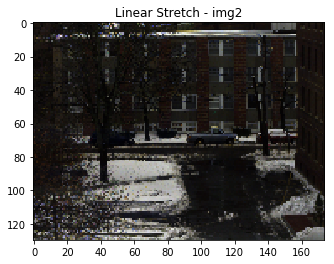

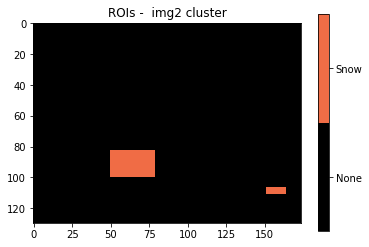

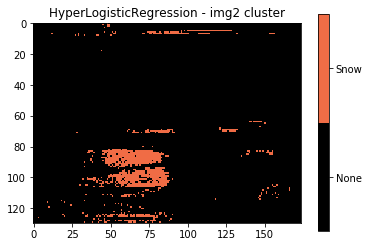

In [3]:
# img2
img2_scaled, img2_cmap = ml.get_scaled_img_and_class_map(source_path, result_path, 'img2', 
                          [['Snow',{'rec':(83,50,100,79)},{'rec':(107,151,111,164)}]],
                          skl.HyperLogisticRegression, {'class_weight':{0:1.0,1:5}},
                          display=True)

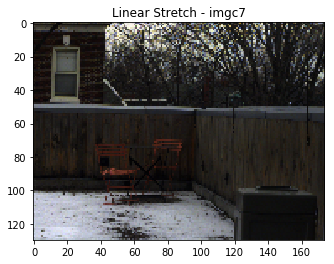

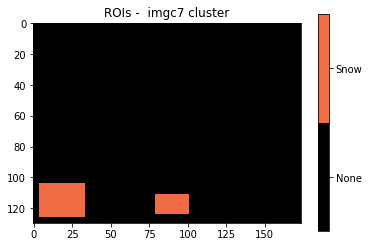

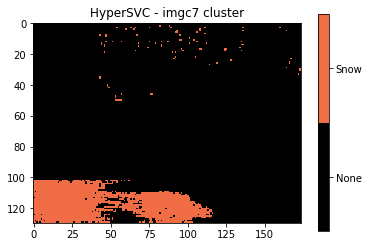

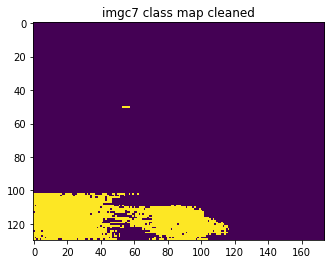

In [4]:
# imgc7
imgc7_scaled, imgc7_cmap = ml.get_scaled_img_and_class_map(source_path, result_path, 'imgc7', 
                          [['Snow',{'rec':(104,4,126,34)},{'rec':(111,79,124,101)}]],
                          skl.HyperSVC, {'class_weight':{0:1,1:10},'gamma':0.5},
                          display=True)
# Clean the top half:
imgc7_cmap[0:50,0:imgc7_cmap.shape[1]] = 0
ml.display_img(imgc7_cmap, 'imgc7 class map cleaned')

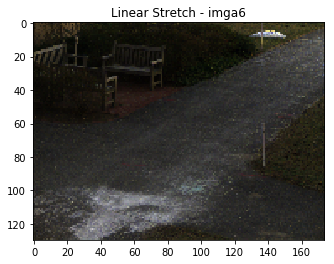

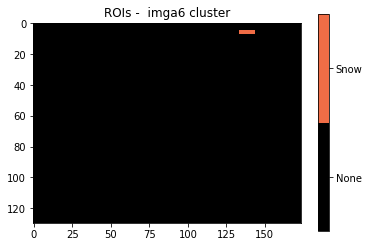

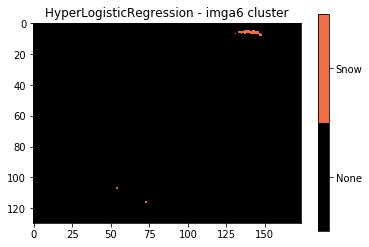

In [5]:
# imga6
imga6_scaled, imga6_cmap = ml.get_scaled_img_and_class_map(source_path, result_path, 'imga6', 
                          [['Snow',{'rec':(5,134,8,144)}]],
                          skl.HyperLogisticRegression, {'class_weight':{0:1.0,1:5}},
                          display=True)

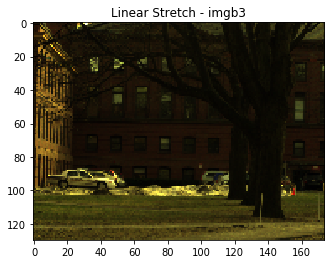

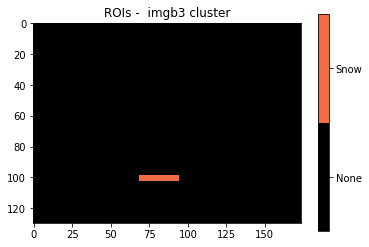

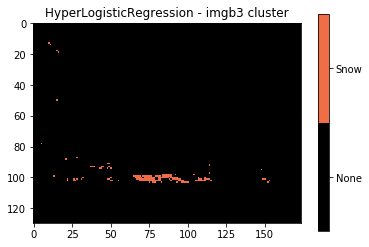

In [6]:
# imgb3
imgb3_scaled, imgb3_cmap = ml.get_scaled_img_and_class_map(source_path, result_path, 'imgb3', 
                          [['Snow',{'rec':(99,69,103,95)}]],
                          skl.HyperLogisticRegression, {'class_weight':{0:1.0,1:5}},
                          display=True)

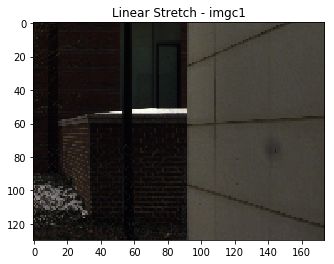

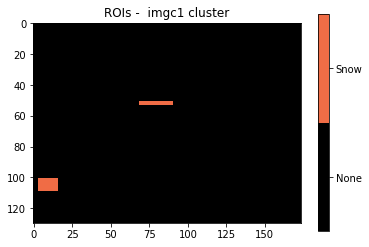

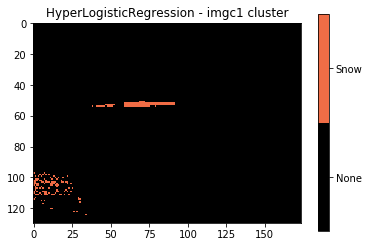

In [7]:
# imgc1
imgc1_scaled, imgc1_cmap = ml.get_scaled_img_and_class_map(source_path, result_path, 'imgc1', 
                          [['Snow',{'rec':(51,69,54,91)},{'rec':(101,3,109,16)}]],
                          skl.HyperLogisticRegression, {'class_weight':{0:1.0,1:5}},
                          display=True)

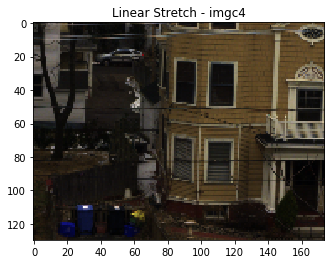

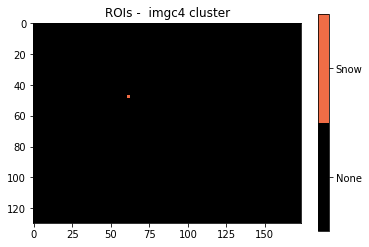

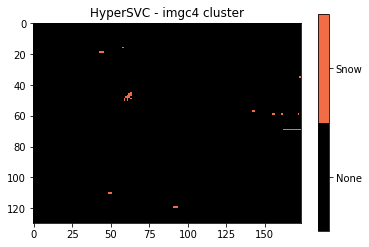

In [8]:
# imgc4
imgc4_scaled, imgc4_cmap = ml.get_scaled_img_and_class_map(source_path, result_path, 'imgc4', 
                          [['Snow',{'rec':(47,61,49,63)}]],
                          skl.HyperSVC, {'class_weight':{0:0.05,1:40}},
                          display=True)

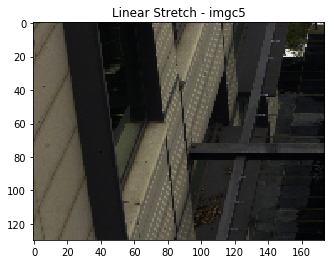

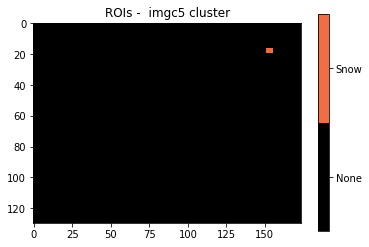

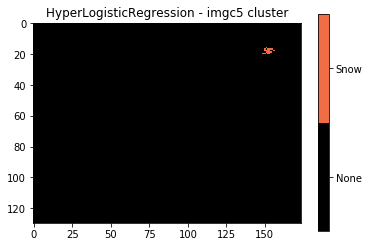

In [9]:
# imgc5
imgc5_scaled, imgc5_cmap = ml.get_scaled_img_and_class_map(source_path, result_path, 'imgc5', 
                          [['Snow',{'rec':(17,151,20,156)}]],
                          skl.HyperLogisticRegression, {'class_weight':{0:1.0,1:5}},
                          display=True)

# Second step: learn

Do a standard learning using LightGBM. It use the HyperLGBMClassifier estimator. See the pysptools.ml module doc.

Accuracy: 98.47%


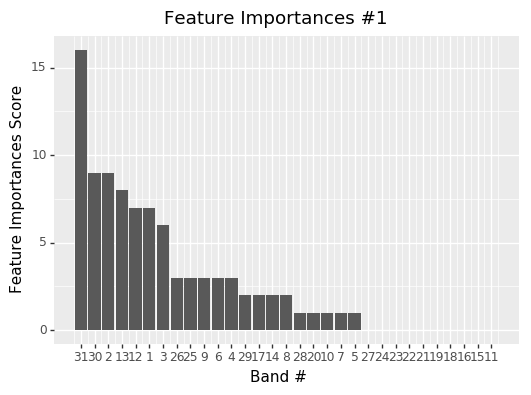

In [10]:
n_shrink = 3

snow_fname = ['img1','img2','imgc7','imga6','imgb3','imgc1','imgc4','imgc5']
nosnow_fname = ['imga1','imgb1','imgb6','imga7']

snow_img = [img1_scaled,img2_scaled,imgc7_scaled,imga6_scaled,
            imgb3_scaled,imgc1_scaled,imgc4_scaled,imgc5_scaled]

nosnow_img = ml.batch_load(source_path, nosnow_fname, n_shrink)

snow_cmap = [img1_cmap,img2_cmap,imgc7_cmap,imga6_cmap,
             imgb3_cmap,imgc1_cmap,imgc4_cmap,imgc5_cmap]

M = snow_img[0]
bkg_cmap = np.zeros((M.shape[0],M.shape[1]))
    
X,y = skl.shape_to_XY(snow_img + nosnow_img, 
                      snow_cmap + [bkg_cmap,bkg_cmap,bkg_cmap,bkg_cmap])

seed = 5
train_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size,
                                                    random_state=seed)
best_param = tune()

model = fit_model(result_path, X_train, y_train, X_test, y_test, 
                  ml.HyperLGBMClassifier, best_param, stat=True)

# Third step: verification

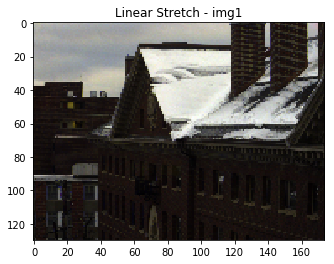

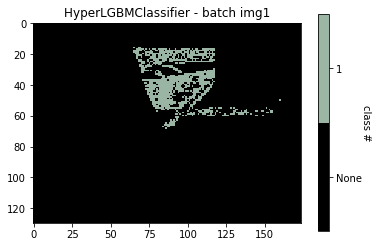

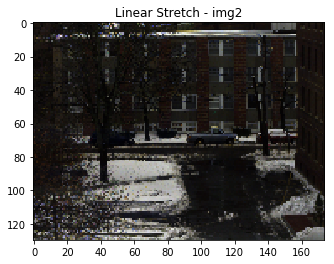

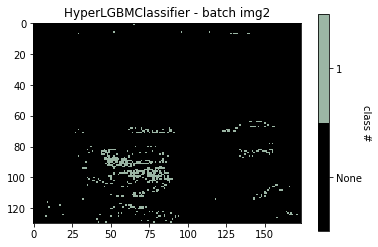

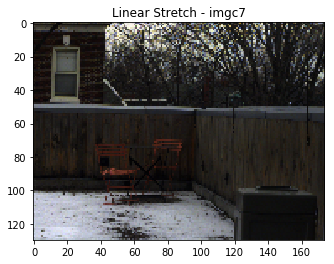

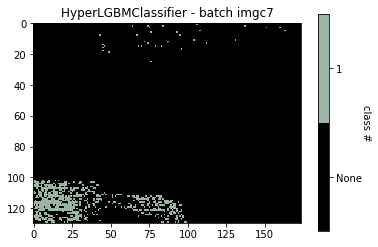

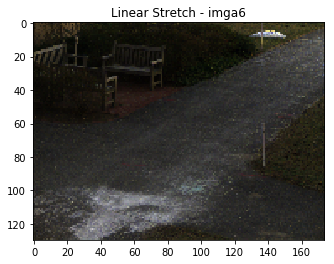

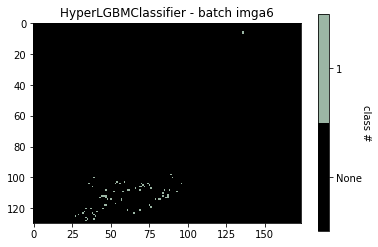

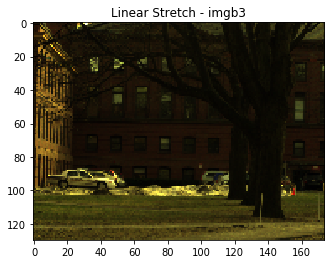

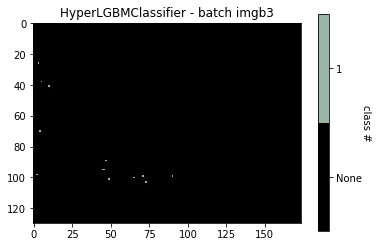

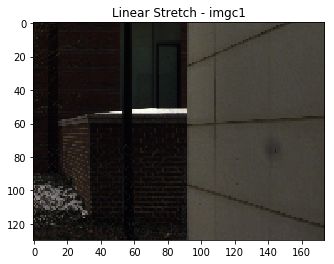

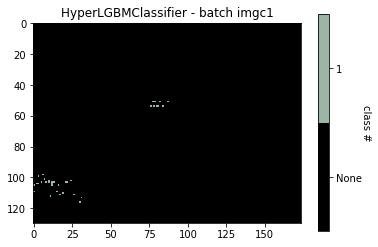

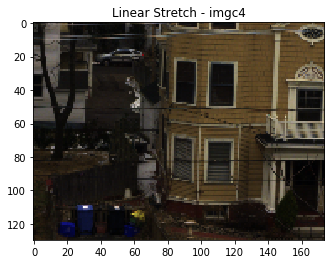

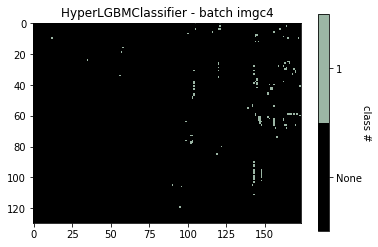

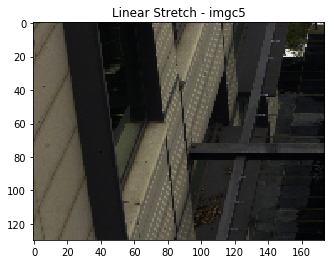

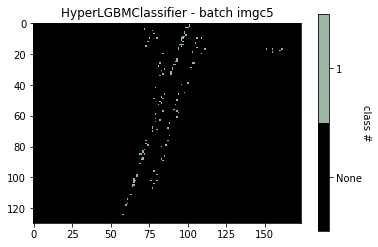

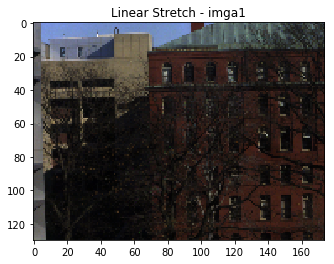

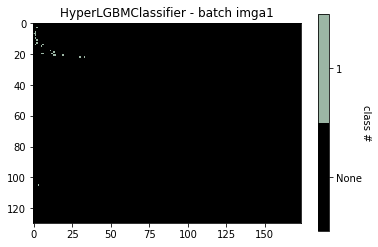

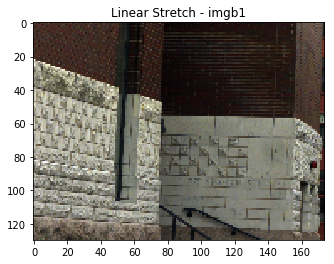

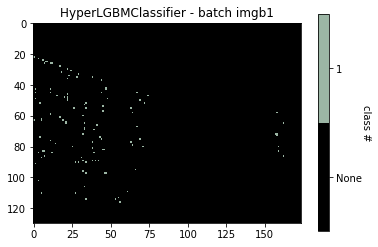

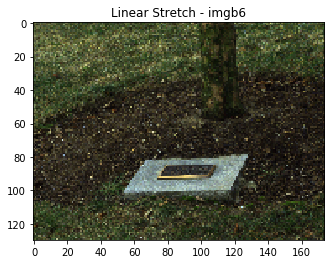

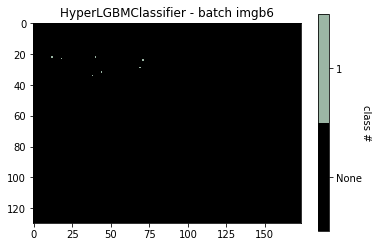

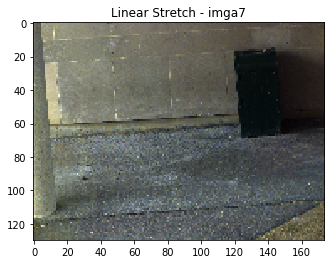

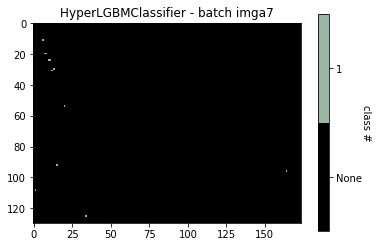

In [11]:
ml.batch_classify(source_path, result_path, model, snow_fname + nosnow_fname, n_shrink)